In [2]:
%%bash
echo "🧹 Removing broken Triton & bitsandbytes folders..."

rm -rf /usr/local/lib/python3.*/dist-packages/triton*
rm -rf /usr/local/lib/python3.*/dist-packages/bitsandbytes*
rm -rf /usr/local/lib/python3.*/dist-packages/bnb*


🧹 Removing broken Triton & bitsandbytes folders...


In [3]:
%%bash
echo "⬇️ Installing PyTorch + bitsandbytes + triton combo known to work"

pip install -q --no-cache-dir torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 \
  -f https://download.pytorch.org/whl/torch_stable.html

pip install -q --no-cache-dir triton==2.1.0.post1
pip install -q --no-cache-dir bitsandbytes==0.43.1

pip install -q --no-cache-dir \
  transformers==4.41.1 peft==0.11.1 accelerate==0.29.3 datasets einops requests


⬇️ Installing PyTorch + bitsandbytes + triton combo known to work
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 94.7 MB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement triton==2.1.0.post1 (from versions: 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 3.0.0, 3.1.0, 3.2.0, 3.3.0, 3.3.1)
ERROR: No matching distribution found for triton==2.1.0.post1


In [1]:
import torch, numpy as np, matplotlib.pyplot as plt, gc
from itertools import islice
import pandas as pd
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import (AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_ID    = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MAX_LEN     = 128
BATCH_SIZE  = 8
STEPS       = 200
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

0it [00:00, ?it/s]

In [2]:
csv_url = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
columns = ["label", "title", "description"]
df = pd.read_csv(csv_url, names=columns)
df = df.sample(frac=1, random_state=42).reset_index(drop=True).head(3200)
df["text"] = df["title"] + ". " + df["description"]
df = df[["text", "label"]].astype({"label": int})

raw_ds = Dataset.from_pandas(df.iloc[:2400])
val_ds = Dataset.from_pandas(df.iloc[2400:])

In [3]:
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def get_base():
    m = AutoModelForCausalLM.from_pretrained(MODEL_ID, quantization_config=bnb_cfg,
                                             device_map="auto")
    return prepare_model_for_kbit_training(m)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
LABEL2ID = {l: i for i, l in enumerate(sorted(set(raw_ds["label"]))) }
prompt = lambda t: f"Classify news: {t}\nLabel:"

def encode(ex):
    inp = tokenizer(prompt(ex["text"]), truncation=True, max_length=MAX_LEN).input_ids
    lab = LABEL2ID[ex["label"]]
    ex["input_ids"] = inp
    ex["labels"]    = inp + [lab] + [tokenizer.eos_token_id]
    return ex

raw_ds = raw_ds.map(encode)
val_ds = val_ds.map(encode)

pad_id = tokenizer.pad_token_id

def collate(batch):
    ids  = [torch.tensor(b["input_ids"], dtype=torch.long) for b in batch]
    lbls = [torch.tensor(b["labels"],    dtype=torch.long) for b in batch]
    min_len = min(len(x) for x in ids + lbls)
    ids  = [x[:min_len] for x in ids]
    lbls = [x[:min_len] for x in lbls]
    return {"input_ids": pad_sequence(ids,  True, pad_id).to(DEVICE),
            "labels":    pad_sequence(lbls, True, -100 ).to(DEVICE)}

train_loader = DataLoader(raw_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
val_loader   = DataLoader(val_ds,  batch_size=BATCH_SIZE, collate_fn=collate)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [5]:
def train_peft(model, steps=STEPS, lr=2e-4, tag=""):
    model.train(); opt = torch.optim.AdamW(model.parameters(), lr=lr)
    losses = []
    for step, batch in enumerate(train_loader, 1):
        opt.zero_grad(set_to_none=True)
        loss = model(**batch).loss; loss.backward(); opt.step()
        losses.append(loss.item())
        if step % 20 == 0 or step == steps:
            print(f"{tag:8s} | step {step:>3}/{steps} | loss {loss.item():.4f}")
        if step >= steps: break
    return np.array(losses)

@torch.no_grad()
def accuracy(model):
    model.eval(); ok = tot = 0
    for batch in val_loader:
        pred = model.generate(batch["input_ids"], max_new_tokens=1)[:, -1].cpu()
        gold = batch["labels"][:, -1].cpu(); tot += len(gold); ok += (pred == gold).sum()
    return ok.item() / tot

In [6]:
lora_cfg  = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.05, target_modules=["q_proj","v_proj"])
qlora_cfg = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.05, target_modules=["q_proj","v_proj"])
draft_cfg = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.05, target_modules=["q_proj","v_proj"], use_dora=True)

model_lora  = get_peft_model(get_base(),  lora_cfg ).to(DEVICE)
model_qlora = get_peft_model(get_base(),  qlora_cfg).to(DEVICE)
model_draft = get_peft_model(get_base(),  draft_cfg).to(DEVICE)

In [7]:
loss_lora  = train_peft(model_lora,  tag="LoRA")
loss_qlora = train_peft(model_qlora, tag="QLoRA")
loss_draft = train_peft(model_draft, tag="DRaFT‡Q")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/

LoRA     | step  20/200 | loss 3.4624


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step  40/200 | loss 2.7689


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step  60/200 | loss 2.2580


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step  80/200 | loss 2.2805


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step 100/200 | loss 2.2985


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step 120/200 | loss 2.6732


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step 140/200 | loss 2.0012


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step 160/200 | loss 2.5684


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step 180/200 | loss 2.0685


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

LoRA     | step 200/200 | loss 2.1860


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step  20/200 | loss 2.6522


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step  40/200 | loss 2.7661


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step  60/200 | loss 2.1639


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step  80/200 | loss 2.4370


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step 100/200 | loss 2.3676


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step 120/200 | loss 2.8184


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step 140/200 | loss 2.1796


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step 160/200 | loss 2.2215


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step 180/200 | loss 2.2178


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

QLoRA    | step 200/200 | loss 2.2584


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step  20/200 | loss 2.6260


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step  40/200 | loss 2.6967


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step  60/200 | loss 2.3454


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step  80/200 | loss 2.3172


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step 100/200 | loss 2.4682


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step 120/200 | loss 2.3056


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step 140/200 | loss 2.2520


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step 160/200 | loss 2.3796


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step 180/200 | loss 1.9324


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

DRaFT‡Q  | step 200/200 | loss 2.4203


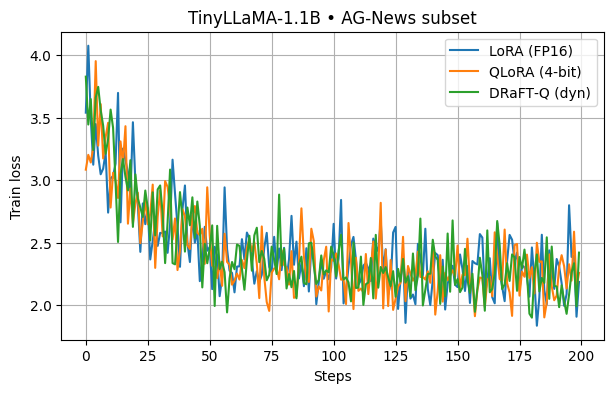

In [8]:
plt.figure(figsize=(7,4))
plt.plot(loss_lora,  label="LoRA (FP16)")
plt.plot(loss_qlora, label="QLoRA (4‑bit)")
plt.plot(loss_draft, label="DRaFT‑Q (dyn)")
plt.title("TinyLLaMA‑1.1B • AG‑News subset")
plt.xlabel("Steps"); plt.ylabel("Train loss"); plt.grid(); plt.legend(); plt.show()

In [9]:
print(f"LoRA    acc: {accuracy(model_lora):.3f}")
print(f"QLoRA   acc: {accuracy(model_qlora):.3f}")
print(f"DRaFT‑Q acc: {accuracy(model_draft):.3f}")

LoRA    acc: 0.003
QLoRA   acc: 0.001
DRaFT‑Q acc: 0.003
